### ADS 509
### Assignment 6.1
### Dingyi Duan
#### GitHub: https://github.com/dingyiduan7/ADS_509_module6

# ADS 509 Sentiment Assignment

This notebook holds the Sentiment Assignment for Module 6 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In a previous assignment you put together Twitter data and lyrics data on two artists. In this assignment we apply sentiment analysis to those data sets. If, for some reason, you did not complete that previous assignment, data to use for this assignment can be found in the assignment materials section of Blackboard. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd
import numpy as np

from collections import Counter, defaultdict
from string import punctuation

from nltk.corpus import stopwords

In [2]:
# Add any additional import statements you need here
import nltk

# punctuation variations
punctuation = set(punctuation) # speeds up comparison
punctuation.add('’') # after seeing many non-English single quote (‘ or ’）, I manually add it into the library
punctuation.add('•') # after seeing many ‘•’, I manually add it into the library
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")
sw = [i.replace("'","") for i in sw]  # remove single quote from sw
sw.append('nan') # add 'nan' to sw - we don't want to see nan's in our tokens 
sw.append('im') # add 'im' to sw - we don't want to see nan's in our tokens

# some cleaning steps
def is_emoji(s):
    
    return emoji.distinct_emoji_list(s)

def remove_emoji(tokens):
    tokens = [i for i in tokens if not is_emoji(i)]
    return tokens

def remove_song_title(s): 
    return re.sub(r'\[.*?\]', '', s)

def lower_case(text):
    return text.casefold()
 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    return text.split()

def remove_stop(tokens) :
    # modify this function to remove stopwords
    tokens = [i for i in tokens if not i in sw]
    return tokens

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return tokens


In [3]:
# change `data_location` to the location of the folder on your machine.
data_location = "D:/USD-ADS_graduate/ADS-509/Module 1/ADS_509_module1/"

# These subfolders should still work if you correctly stored the 
# data from the Module 1 assignment
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

positive_words_file = "positive-words.txt"
negative_words_file = "negative-words.txt"
tidy_text_file = "tidytext_sentiments.txt"

## Data Input

Now read in each of the corpora. For the lyrics data, it may be convenient to store the entire contents of the file to make it easier to inspect the titles individually, as you'll do in the last part of the assignment. In the solution, I stored the lyrics data in a dictionary with two dimensions of keys: artist and song. The value was the file contents. A Pandas data frame would work equally well. 

For the Twitter data, we only need the description field for this assignment. Feel free all the descriptions read it into a data structure. In the solution, I stored the descriptions as a dictionary of lists, with the key being the artist. 




In [4]:
# Read in the lyrics data

"""
read the files into lists and use the lists to make a dataframe
"""
lyrics_path = data_location + lyrics_folder
artists = os.listdir(lyrics_path)

a = []
b = []


for artist in artists:
    raw_song = os.listdir(lyrics_path+artist)
    for song in raw_song:
        a.append(str(artist))
        f = open(lyrics_path+artist+'/'+song, "r")
        song = re.search('_(.+?).txt',song).group(1)
        b.append(f.read())

lyrics_df = pd.DataFrame({'artist':a,
                           'lyrics':b
                         })

lyrics_df.sample(10)

,artist,lyrics
22,Mariah Carey,['Vanishing']\n\nIf I could recapture all of t...
7,Mariah Carey,['Hero']\n\nThere's a hero\nIf you look inside...
51,Nicki Minaj,"['Wuchoo Know']\n\nChin checker, chin checker\..."
15,Mariah Carey,['Sent From Up Above']\n\nI don't wanna live w...
17,Mariah Carey,['Some Day']\n\nYou were so blind to let me go...
26,Nicki Minaj,"['1900 Ms Minaj']\n\nYoung Big Mike, Dirty Mon..."
50,Nicki Minaj,['Warning']\n\n[Nicki Minaj:]\nWho the hell is...
8,Mariah Carey,['I Don't Wanna Cry']\n\nOnce again we sit in ...
25,Mariah Carey,['You're So Cold']\n\nLord only knows\nWhy I l...
35,Nicki Minaj,"['Freestyle']\n\nI don't want to sound mad, th..."


In [5]:
# Read in the twitter data

"""
manually read those files into dataframe's columns
"""
twitter_path = data_location + twitter_folder
twitter_files = os.listdir(twitter_path)

mariah_df = pd.DataFrame()
nicki_df = pd.DataFrame()

mariah_des = pd.read_csv(os.path.join(twitter_path, 'MariahCarey_followers.txt'),sep='\t')['description']
nicki_des = pd.read_csv(os.path.join(twitter_path, 'NICKIMINAJ_followers.txt'),sep='\t')['description']

mariah_df['artist'] = ['Mariah Carey']*len(mariah_des)
mariah_df['description'] = mariah_des

nicki_df['artist'] = ['Nicki Minaj']*len(nicki_des)
nicki_df['description'] = nicki_des

twitter_df = pd.concat([mariah_df,nicki_df],ignore_index=True)
twitter_df['description'] = twitter_df['description'].astype(str)

twitter_df.sample(10)

,artist,description
174641,Nicki Minaj,nan
70474,Mariah Carey,#fuckthesupremecourt My loves include anime (e...
113933,Nicki Minaj,nan
122627,Nicki Minaj,just 4 fun
152700,Nicki Minaj,nan
110603,Nicki Minaj,19
29708,Mariah Carey,nan
59620,Mariah Carey,O.D.A.A.T Don't give into Fame at the expense ...
106309,Nicki Minaj,nan
80159,Mariah Carey,nan


In [6]:
# Read in the positive and negative words and the
# tidytext sentiment. Store these so that the positive
# words are associated with a score of +1 and negative words
# are associated with a score of -1. You can use a dataframe or a 
# dictionary for this.
good_words = pd.read_csv('D:/USD-ADS_graduate/ADS-509/Module 6/ADS_509_module6/positive-words.txt',sep='\t',encoding = 'latin-1')
bad_words = pd.read_csv('D:/USD-ADS_graduate/ADS-509/Module 6/ADS_509_module6/negative-words.txt',sep='\t',encoding = 'latin-1')
tidytext = pd.read_csv('D:/USD-ADS_graduate/ADS-509/Module 6/ADS_509_module6/tidytext_sentiments.txt',sep='\t',encoding = 'latin-1')

In [7]:
tidytext = tidytext.drop(['lexicon'],axis=1)
good_words = good_words.drop(range(33))
bad_words = bad_words.drop(range(33))

In [8]:
# append the good words and bad words to the tidytext dataframe 
good_words['sentiment'] = 'positive'
good_words.rename(columns={good_words.columns[0]: "word"}, inplace = True)
bad_words['sentiment'] = 'negative'
bad_words.rename(columns={bad_words.columns[0]: "word"}, inplace = True)

In [9]:
# concatenate all three dfs and remove duplicates and reset the index
word_df = pd.concat([tidytext, good_words, bad_words]).drop_duplicates(subset=['word']).reset_index(drop=True)
word_df

,word,sentiment
0,abandon,negative
1,abandoned,negative
2,abandonment,negative
3,abba,positive
4,abduction,negative
...,...,...
11403,tremendous,positive
11404,upturn,positive
11405,upturns,positive
11406,vibrancy,positive


In [10]:
# check for duplicated words
word_df.loc[word_df['word'].duplicated()].sum()

word         0.0
sentiment    0.0
dtype: float64

No duplicates.

In [11]:
# map the positive words are associated with a score 
# of +1 and negative words are associated with a score of -1
sentiment_map = {'positive':1, 'negative':-1}
word_df["sentiment"] = word_df["sentiment"].map(sentiment_map)
word_df["sentiment"] = word_df['sentiment'].astype(int) # make sure they are integers
word_df

,word,sentiment
0,abandon,-1
1,abandoned,-1
2,abandonment,-1
3,abba,1
4,abduction,-1
...,...,...
11403,tremendous,1
11404,upturn,1
11405,upturns,1
11406,vibrancy,1


In [12]:
# create the sentiment score calculator/function
def sentiment_score(list_of_tokens):
    sentiment_score = 0
    for token in list_of_tokens:
        if token in word_df['word'].tolist():
            sentiment_score += word_df['sentiment'].loc[word_df['word']==token].values[0]
    return sentiment_score / len(list_of_tokens) if len(list_of_tokens)>0 else 0

## Sentiment Analysis on Songs

In this section, score the sentiment for all the songs for both artists in your data set. Score the sentiment by manually calculating the sentiment using the combined lexicons provided in this repository. 

After you have calculated these sentiments, answer the questions at the end of this section.


In [13]:
lyrics_pipeline = [remove_song_title,lower_case, remove_punctuation, tokenize, remove_stop]
lyrics_df['tokens'] = lyrics_df['lyrics'].apply(prepare,pipeline=lyrics_pipeline)
lyrics_df['sentiment_scores'] =  lyrics_df['tokens'].apply(sentiment_score)
lyrics_df

,artist,lyrics,tokens,sentiment_scores
0,Mariah Carey,['All In Your Mind']\n\nCome closer\nYou seem ...,"[come, closer, seem, far, away, theres, someth...",0.191781
1,Mariah Carey,['Alone In Love']\n\nSwept me away\nBut now I'...,"[swept, away, lost, dark, set, fire, left, spa...",-0.094828
2,Mariah Carey,['And You Don't Remember']\n\nShattered dreams...,"[shattered, dreams, cut, mind, tragically, lov...",-0.089109
3,Mariah Carey,['Any Time You Need A Friend']\n\nIf you're lo...,"[lonely, need, friend, troubles, seem, like, n...",-0.006897
4,Mariah Carey,"['Can't Let Go']\n\nThere you are, holding her...","[holding, hand, lost, dying, understand, cheri...",-0.032000
5,Mariah Carey,['Dream Lover']\n\nI need a lover to give me\n...,"[need, lover, give, kind, love, last, always, ...",0.162791
6,Mariah Carey,['Emotions']\n\nYou've got me feeling emotions...,"[got, feeling, emotions, deeper, ive, ever, dr...",0.070312
7,Mariah Carey,['Hero']\n\nThere's a hero\nIf you look inside...,"[theres, hero, look, inside, heart, afraid, th...",0.149123
8,Mariah Carey,['I Don't Wanna Cry']\n\nOnce again we sit in ...,"[sit, silence, said, done, emptiness, inside, ...",-0.106918
9,Mariah Carey,['If It's Over']\n\nWon't you talk to me\nThis...,"[talk, hand, somethings, gone, wrong, life, pl...",0.153846


In [14]:
sent_mc = lyrics_df['sentiment_scores'].loc[lyrics_df['artist']=='Mariah Carey']
avg_sent_mc = sent_mc.sum() / len(sent_mc)
print('The average sentiment per song for Mariah Carey is: ', round(avg_sent_mc,3),'\n')

sent_nm = lyrics_df['sentiment_scores'].loc[lyrics_df['artist']=='Nicki Minaj']
avg_sent_nm = sent_nm.sum() / len(sent_nm)
print('The average sentiment per song for Nicki Minaj is: ', round(avg_sent_nm,3),'\n')

The average sentiment per song for Mariah Carey is:  0.054 

The average sentiment per song for Nicki Minaj is:  -0.01 



In [15]:
# For Mariah Carey

# find the highest and lowest songs
highest_sent_mc = lyrics_df['lyrics'].loc[lyrics_df['sentiment_scores'] == sent_mc.max()]  
highest_sent_mc = highest_sent_mc.astype('string').values[0]
lowest_sent_mc = lyrics_df['lyrics'].loc[lyrics_df['sentiment_scores'] == sent_mc.min()]
lowest_sent_mc = lowest_sent_mc.astype('string').values[0]

# extract the titles by finding contents in between "[" and "]"
print ("For the first artist ('Mariah Carey'), the song", highest_sent_mc[highest_sent_mc.find("[")+1:highest_sent_mc.find("]")], "have the highest sentiments with a sentiment score of ",round(sent_mc.max(),3))
print ("For the first artist ('Mariah Carey'), the song", lowest_sent_mc[lowest_sent_mc.find("[")+1:lowest_sent_mc.find("]")], "have the lowest sentiments with a sentiment score of ",round(sent_mc.min(),3))

For the first artist ('Mariah Carey'), the song 'Vision Of Love' have the highest sentiments with a sentiment score of  0.275
For the first artist ('Mariah Carey'), the song 'You're So Cold' have the lowest sentiments with a sentiment score of  -0.224


In [16]:
# For Nicki Minaj

# find the highest and lowest songs
highest_sent_nm = lyrics_df['lyrics'].loc[lyrics_df['sentiment_scores'] == sent_nm.max()]  
highest_sent_nm = highest_sent_nm.astype('string').values[0]
lowest_sent_nm = lyrics_df['lyrics'].loc[lyrics_df['sentiment_scores'] == sent_nm.min()]
lowest_sent_nm = lowest_sent_nm.astype('string').values[0]

# extract the titles by finding contents in between "[" and "]"
print ("For the second artist ('Nicki Minaj'), the song", highest_sent_nm[highest_sent_nm.find("[")+1:highest_sent_nm.find("]")], "have the highest sentiments.",round(sent_nm.max(),3))
print ("For the second artist ('Nicki Minaj'), the song", lowest_sent_nm[lowest_sent_nm.find("[")+1:lowest_sent_nm.find("]")], "have the lowest sentiments.",round(sent_nm.min(),3))

For the second artist ('Nicki Minaj'), the song 'Sunshine 284199' have the highest sentiments. 0.12
For the second artist ('Nicki Minaj'), the song 'Brraaattt' have the lowest sentiments. -0.348


### Questions

Q: Overall, which artist has the higher average sentiment per song? 

A: <b>Mariah Carey</b> has the higher average sentiment per song of <b>0.054</b>.


---

Q: For your first artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

A: <b>'Vision Of Love'</b> has the highest sentiments of <b>0.275</b> and <b>'You're So Cold'</b> has the lowest sentiments of <b>-0.224</b>.

---

Q: For your second artist, what songs have the highest and lowest sentiments? Print those songs to the screen.

A: <b>'Sunshine 284199'</b> has the highest sentiments of <b>0.12</b> and <b>'Brraaattt'</b> has the lowest sentiments of <b>-0.348</b>.

---

Q: Plot the distributions of the sentiment scores for both artists. You can use `seaborn` to plot densities or plot histograms in matplotlib.




artist
Mariah Carey    AxesSubplot(0.125,0.11;0.775x0.77)
Nicki Minaj     AxesSubplot(0.125,0.11;0.775x0.77)
Name: sentiment_scores, dtype: object

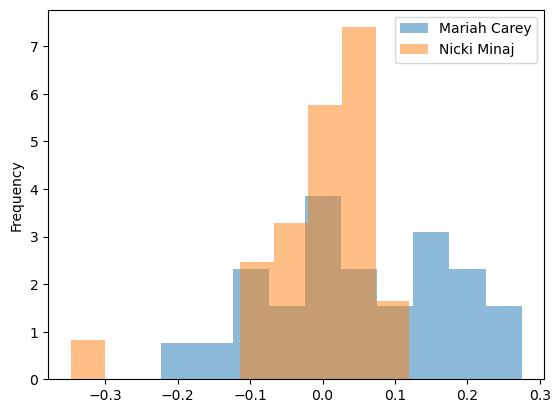

In [17]:
lyrics_df.groupby('artist')['sentiment_scores'].plot(kind="hist",density=True,alpha=0.5,legend=True)

It's pretty obvious that most of Mariah's songs are more uplifting except for a few ones; While Nicki's songs are more "hatred" oriented as the nature of most rap songs.

## Sentiment Analysis on Twitter Descriptions

In this section, define two sets of emojis you designate as positive and negative. Make sure to have at least 10 emojis per set. You can learn about the most popular emojis on Twitter at [the emojitracker](https://emojitracker.com/). 

Associate your positive emojis with a score of +1, negative with -1. Score the average sentiment of your two artists based on the Twitter descriptions of their followers. The average sentiment can just be the total score divided by number of followers. 

In [45]:
'''
Found an emoji sentiment lexicon csv online

Reference:
Kralj Novak, P., Smailović, J., Sluban, B., &amp; Mozetič, I. (2015, September 14). 
Emoji sentiment ranking 1.0. Emoji Sentiment Ranking 1.0. Retrieved October 14, 2022, 
from https://www.clarin.si/repository/xmlui/handle/11356/1048 

'''
emoji_df = pd.read_csv('D:/USD-ADS_graduate/ADS-509/Module 6/ADS_509_module6/Emoji_Sentiment_Data_v1.0.csv')
emoji_df.head()

,Emoji,Unicode codepoint,Occurrences,Position,Negative,Neutral,Positive,Unicode name,Unicode block
0,😂,0x1f602,14622,0.805101,3614,4163,6845,FACE WITH TEARS OF JOY,Emoticons
1,❤,0x2764,8050,0.746943,355,1334,6361,HEAVY BLACK HEART,Dingbats
2,♥,0x2665,7144,0.753806,252,1942,4950,BLACK HEART SUIT,Miscellaneous Symbols
3,😍,0x1f60d,6359,0.765292,329,1390,4640,SMILING FACE WITH HEART-SHAPED EYES,Emoticons
4,😭,0x1f62d,5526,0.803352,2412,1218,1896,LOUDLY CRYING FACE,Emoticons


In [19]:
# perform a little clean-up
# remove unnecessary cols
emoji_df = emoji_df.drop(['Unicode codepoint','Position','Neutral','Unicode name','Unicode block'],axis=1)

# remove rare emojis and rows of 'Positive' = 'Negative'
emoji_df = emoji_df[(emoji_df['Occurrences'] > 10) & (emoji_df['Negative'] != emoji_df['Positive'])]


# set sentiment score
def emoji_map(row):
    if row['Positive'] > row['Negative']:
        return 1 
    else: 
        return -1
    
emoji_df['sentiment'] = emoji_df.apply(lambda row: emoji_map(row), axis=1)
emoji_df = emoji_df.drop(['Negative', 'Positive','Occurrences'],axis=1)
emoji_df

,Emoji,sentiment
0,😂,1
1,❤,1
2,♥,1
3,😍,1
4,😭,-1
...,...,...
586,🚣,1
588,🏉,1
589,🗻,1
590,🐀,1


In [20]:
# create the sentiment score calculator/function for emojis
def sentiment_score_emoji(list_of_tokens):
    sentiment_score_emoji = 0
    for token in list_of_tokens:
        if token in emoji_df['Emoji'].tolist():
            sentiment_score_emoji += emoji_df['sentiment'].loc[emoji_df['Emoji']==token].values[0]
    return sentiment_score_emoji / len(list_of_tokens) if len(list_of_tokens)>0 else 0

In [21]:
# for follower descriptions, we'll separate tokens and emojis

twitter_pipeline = [lower_case, remove_punctuation, tokenize, remove_stop]
twitter_df['tokens'] = twitter_df['description'].apply(prepare,pipeline=twitter_pipeline)
twitter_df['emojis'] = twitter_df['description'].apply(is_emoji)
twitter_df['sentiment_scores'] =  twitter_df['tokens'].apply(sentiment_score)
twitter_df['sentiment_scores_emoji'] =  twitter_df['tokens'].apply(sentiment_score_emoji)

In [22]:
twitter_df['combined_score'] = twitter_df['sentiment_scores']+twitter_df['sentiment_scores_emoji']

In [49]:
twitter_df.sample(10)

,artist,description,tokens,emojis,sentiment_scores,sentiment_scores_emoji,combined_score
90217,Mariah Carey,nan,[],[],0.000000,0.000000,0.000000
189999,Nicki Minaj,Pharmacy technician 💊,"[pharmacy, technician, 💊]",[💊],0.000000,0.333333,0.333333
125626,Nicki Minaj,(he/ him),[],[],0.000000,0.000000,0.000000
143278,Nicki Minaj,nan,[],[],0.000000,0.000000,0.000000
35819,Mariah Carey,Mr https://t.co/Qy5USKeOOr robot...@mariogooma...,"[mr, httpstcoqy5uskeoor, robotmariogoomare, pa...",[🇰🇪],0.000000,0.000000,0.000000
56835,Mariah Carey,I refuse to believe guillermo is in love with ...,"[refuse, believe, guillermo, love, nandor, 💀💀💀]",[💀],0.000000,0.000000,0.000000
133849,Nicki Minaj,nan,[],[],0.000000,0.000000,0.000000
12527,Mariah Carey,nan,[],[],0.000000,0.000000,0.000000
89666,Mariah Carey,Me gusta mucho leer feminist estudiante de enf...,"[gusta, mucho, leer, feminist, estudiante, de,...",[],-0.142857,0.000000,-0.142857
6832,Mariah Carey,Official Page: @cecilia_gems 🌿| Everyday Rare ...,"[official, page, ceciliagems, 🌿, everyday, rar...","[🕊, 🇬🇷, 🏛, ✨, 🌿]",0.000000,0.058824,0.058824


In [29]:
# average twitter sentiment for Mariah Carey
tw_sen_mc = twitter_df['combined_score'].loc[twitter_df['artist']=='Mariah Carey']
tw_avg_sen_mc = tw_sen_mc.sum() / len(tw_sen_mc)
print('The average twitter sentiment for Mariah Carey is: ', round(tw_avg_sen_mc,3),'\n')

# average twitter sentiment for Nicki Minaj
tw_sen_nm = twitter_df['combined_score'].loc[twitter_df['artist']=='Nicki Minaj']
tw_avg_sen_nm = tw_sen_nm.sum() / len(tw_sen_nm)
print('The average twitter sentiment for Nicki Minaj is: ', round(tw_avg_sen_nm,3),'\n')

The average twitter sentiment for Mariah Carey is:  0.064 

The average twitter sentiment for Nicki Minaj is:  0.029 



In [25]:
emoji_mc = twitter_df['emojis'].loc[twitter_df['artist']=='Mariah Carey'].tolist()
emoji_nm = twitter_df['emojis'].loc[twitter_df['artist']=='Nicki Minaj'].tolist()

# all emojis for Mariah Carey
emoji_mc_sum = []
for i in range(len(emoji_mc)):
    emoji_mc_sum = emoji_mc_sum + emoji_mc[i] # use + to stitch all list together
    
# all positive emojis for Mariah Carey
all_pos_emoji_mc = [i for i in emoji_mc_sum if i in emoji_df['Emoji'].loc[emoji_df['sentiment']==1].tolist()]
# all negative emojis for Mariah Carey
all_neg_emoji_mc = [i for i in emoji_mc_sum if i in emoji_df['Emoji'].loc[emoji_df['sentiment']==-1].tolist()]

# all emojis for Nicki Minaj  
emoji_nm_sum = []
for i in range(len(emoji_nm)):
    emoji_nm_sum = emoji_nm_sum + emoji_nm[i] # use + to stitch all list together
    
# all positive emojis for Nicki Minaj  
all_pos_emoji_nm = [i for i in emoji_nm_sum if i in emoji_df['Emoji'].loc[emoji_df['sentiment']==1].tolist()]
# all negative emojis for Nicki Minaj  
all_neg_emoji_nm = [i for i in emoji_nm_sum if i in emoji_df['Emoji'].loc[emoji_df['sentiment']==-1].tolist()]

In [26]:
print('For Mariah Carey, the positive emoji:',Counter(all_pos_emoji_mc).most_common()[:1][0][0],'is the most popular with a frequency of', Counter(all_pos_emoji_mc).most_common()[:1][0][1])
print('and the negative emoji:',Counter(all_neg_emoji_mc).most_common()[:1][0][0],'is the most popular with a frequency of',Counter(all_neg_emoji_mc).most_common()[:1][0][1],'\n')


print('For Nicki Minaj, the positive emoji:',Counter(all_pos_emoji_nm).most_common()[:1][0][0],'is the most popular with a frequency of', Counter(all_pos_emoji_nm).most_common()[:1][0][1])
print('and the negative emoji:',Counter(all_neg_emoji_nm).most_common()[:1][0][0],'is the most popular with a frequency of',Counter(all_neg_emoji_nm).most_common()[:1][0][1],'\n')

For Mariah Carey, the positive emoji: ✨ is the most popular with a frequency of 948
and the negative emoji: 🔞 is the most popular with a frequency of 109 

For Nicki Minaj, the positive emoji: ✨ is the most popular with a frequency of 895
and the negative emoji: 💔 is the most popular with a frequency of 131 



### Questions


Q: What is the average sentiment of your two artists? 

A: The average twitter sentiment for <b>Mariah Carey</b> is:  <b>0.064</b>, the average twitter sentiment for <b>Nicki Minaj</b> is:  <b>0.029</b>.

---

Q: Which positive emoji is the most popular for each artist? Which negative emoji? 

A: For <b>Mariah Carey</b>, the positive emoji: ✨ is the most popular with a frequency of <b>948</b>
and the negative emoji: 🔞 is the most popular with a frequency of <b>109</b>.

For <b>Nicki Minaj</b>, the positive emoji: ✨ is the most popular with a frequency of <b>895</b>
and the negative emoji: 💔 is the most popular with a frequency of <b>131</b>.

